In [18]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
import urllib
from keras import models
from keras import layers
import seaborn as sns
import os
import tensorflow as tf
from audio_classification.preprocess import preprocess
from sklearn import preprocessing
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from audio_classification.dnn_simple_classifier.dnn_simple_classifier import DNNSimpleClassifier

In [19]:
NUMBER_OF_MFCCS = 13
CLIP_SIZE = 1290
SAMPLE_SHAPE = (NUMBER_OF_MFCCS, CLIP_SIZE, 1)
MODEL_PATH = DNNSimpleClassifier.MODEL_PATH

In [11]:
data, similarity = preprocess(NUMBER_OF_MFCCS)

le = preprocessing.LabelEncoder()
transformed = le.fit_transform(data['label'])
l = []
for index, row in data.iterrows():
    arr = np.load(row['file'])
    l.append(arr[:, :CLIP_SIZE])
    
X = np.expand_dims(np.stack(l), axis=3)
y = np.array(transformed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=666)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, random_state=666)

Cached features found


In [12]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

In [21]:
model = models.Sequential()

model.add(layers.Input(shape=SAMPLE_SHAPE, name='input'))
model.add(layers.AveragePooling2D(pool_size=(1, CLIP_SIZE)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_1 (Average (None, 13, 1, 1)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               3584      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)               

In [22]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
history = model.fit(X_train,
    y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_valid, y_valid),
    callbacks=[
        ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True),
#         EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=5, min_delta=0.01)
    ]
)

Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 7.4633 - accuracy: 0.1300
Epoch 00001: val_accuracy improved from -inf to 0.13500, saving model to models/simple_dnn/model.h5
38/38 [==============================] - 1s 16ms/step - loss: 7.4633 - accuracy: 0.1300 - val_loss: 2.4958 - val_accuracy: 0.1350
Epoch 2/100
35/38 [==========================>...] - ETA: 0s - loss: 2.9667 - accuracy: 0.1714
Epoch 00002: val_accuracy improved from 0.13500 to 0.17500, saving model to models/simple_dnn/model.h5
38/38 [==============================] - 0s 11ms/step - loss: 2.9235 - accuracy: 0.1717 - val_loss: 2.2705 - val_accuracy: 0.1750
Epoch 3/100
33/38 [=========================>....] - ETA: 0s - loss: 2.5226 - accuracy: 0.1837
Epoch 00003: val_accuracy improved from 0.17500 to 0.24500, saving model to models/simple_dnn/model.h5
38/38 [==============================] - 0s 11ms/step - loss: 2.4810 - accuracy: 0.1900 - val_loss: 2.1913 - val_accuracy: 0.2450
Epoch 4/100
33/38 [

Epoch 28/100
33/38 [=========================>....] - ETA: 0s - loss: 1.4810 - accuracy: 0.4545
Epoch 00028: val_accuracy improved from 0.46000 to 0.47000, saving model to models/simple_dnn/model.h5
38/38 [==============================] - 0s 11ms/step - loss: 1.4721 - accuracy: 0.4583 - val_loss: 1.4937 - val_accuracy: 0.4700
Epoch 29/100
37/38 [============================>.] - ETA: 0s - loss: 1.4526 - accuracy: 0.4611
Epoch 00029: val_accuracy improved from 0.47000 to 0.48500, saving model to models/simple_dnn/model.h5
38/38 [==============================] - 1s 16ms/step - loss: 1.4546 - accuracy: 0.4600 - val_loss: 1.5133 - val_accuracy: 0.4850
Epoch 30/100
35/38 [==========================>...] - ETA: 0s - loss: 1.4555 - accuracy: 0.4750
Epoch 00030: val_accuracy did not improve from 0.48500
38/38 [==============================] - 1s 13ms/step - loss: 1.4636 - accuracy: 0.4717 - val_loss: 1.5071 - val_accuracy: 0.4400
Epoch 31/100
35/38 [==========================>...] - ETA: 0s

Epoch 56/100
35/38 [==========================>...] - ETA: 0s - loss: 1.0278 - accuracy: 0.6232
Epoch 00056: val_accuracy did not improve from 0.57500
38/38 [==============================] - 0s 11ms/step - loss: 1.0386 - accuracy: 0.6183 - val_loss: 1.1993 - val_accuracy: 0.5700
Epoch 57/100
34/38 [=========================>....] - ETA: 0s - loss: 1.0202 - accuracy: 0.6140
Epoch 00057: val_accuracy improved from 0.57500 to 0.60000, saving model to models/simple_dnn/model.h5
38/38 [==============================] - 0s 11ms/step - loss: 1.0148 - accuracy: 0.6167 - val_loss: 1.1859 - val_accuracy: 0.6000
Epoch 58/100
35/38 [==========================>...] - ETA: 0s - loss: 0.9985 - accuracy: 0.6500
Epoch 00058: val_accuracy did not improve from 0.60000
38/38 [==============================] - 0s 11ms/step - loss: 1.0113 - accuracy: 0.6417 - val_loss: 1.1821 - val_accuracy: 0.5700
Epoch 59/100
36/38 [===========================>..] - ETA: 0s - loss: 0.9890 - accuracy: 0.6458
Epoch 00059: 

36/38 [===========================>..] - ETA: 0s - loss: 0.6988 - accuracy: 0.7344
Epoch 00084: val_accuracy did not improve from 0.63500
38/38 [==============================] - 0s 12ms/step - loss: 0.7097 - accuracy: 0.7283 - val_loss: 1.1450 - val_accuracy: 0.6000
Epoch 85/100
33/38 [=========================>....] - ETA: 0s - loss: 0.7139 - accuracy: 0.7292
Epoch 00085: val_accuracy improved from 0.63500 to 0.65000, saving model to models/simple_dnn/model.h5
38/38 [==============================] - 0s 12ms/step - loss: 0.7056 - accuracy: 0.7367 - val_loss: 1.0560 - val_accuracy: 0.6500
Epoch 86/100
37/38 [============================>.] - ETA: 0s - loss: 0.7031 - accuracy: 0.7348
Epoch 00086: val_accuracy did not improve from 0.65000
38/38 [==============================] - 0s 11ms/step - loss: 0.7041 - accuracy: 0.7333 - val_loss: 1.1320 - val_accuracy: 0.6200
Epoch 87/100
33/38 [=========================>....] - ETA: 0s - loss: 0.6615 - accuracy: 0.7595
Epoch 00087: val_accuracy 

<Figure size 576x432 with 0 Axes>

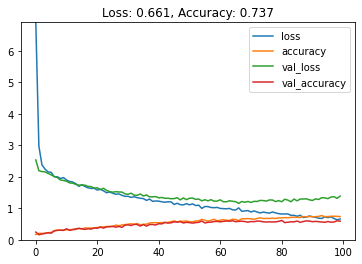

In [16]:
plot_loss_accuracy(history)

In [17]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 10ms/step - loss: 1.5918 - accuracy: 0.5350


[1.591825008392334, 0.5350000262260437]